In [1]:
%matplotlib notebook

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import anndata as ad
from load_data import save_anndata, load_anndata

from synthesize import SyntheticDataset, sample_gaussian, sample_truncated_gaussian
from scipy.stats import gamma, bernoulli
from pathlib import Path

In [3]:
def synthesize_average_expressions(num_genes, cell_type_variation_probabilities, shape_parameter, normalize=True):
    """Synthesize related metagenes according to the metagene_variation_probabilities vector.

    """
    
    num_cell_type_components = len(cell_type_variation_probabilities) 
    expression_profiles = np.zeros((num_cell_type_components, num_genes))
    
    for index in range(num_cell_type_components):
        variation_probability = cell_type_variation_probabilities[index]
        if variation_probability == 0:
            expression_profile = gamma.rvs(shape_parameter, size=num_genes)
            expression_profiles[index] = expression_profile
        else:
            rng = np.random.default_rng()
            mask = rng.choice(num_genes, size=int(num_genes * variation_probability), replace=False)

            perturbed_expression_profile = np.array(expression_profile)
            perturbed_expression_profile[mask] = gamma.rvs(shape_parameter, size=len(mask))
        
            expression_profiles[index] = perturbed_expression_profile
        
            
    print("Difference between Inhibitory 1 and Inhibitory 2: %f" % ((expression_profiles[0] != expression_profiles[1]).sum() / num_genes))
    print("Difference between Non-Neuron L1 and Non-Neuron Ubiquitous: %f" % ((expression_profiles[2] != expression_profiles[3]).sum() / num_genes))
    print("Difference between Excitatory L1 and Excitatory L2: %f" % ((expression_profiles[4] != expression_profiles[5]).sum() / num_genes))
    print("Difference between Excitatory L3 and Excitatory L2: %f" % ((expression_profiles[6] != expression_profiles[5]).sum() / num_genes))
    print("Difference between Excitatory L1 and Excitatory L4: %f" % ((expression_profiles[4] != expression_profiles[7]).sum() / num_genes))
    print("Difference between Excitatory L3 and Excitatory L4: %f" % ((expression_profiles[6] != expression_profiles[7]).sum() / num_genes))

    return expression_profiles

In [4]:
layer_distributions = [
    pd.Series(data=
        dict(zip(["Excitatory L1", "Inhibitory 1", "Non-Neuron L1", "Non-Neuron Ubiquitous"],
                 [0.33, 0.1, 0.5, 0.07]))),
    pd.Series(data=
        dict(zip(["Excitatory L2","Non-Neuron Ubiquitous"],
                 [0.93, 0.07]))),
    pd.Series(data=
        dict(zip(["Excitatory L3", "Inhibitory 1", "Inhibitory 2", "Non-Neuron Ubiquitous"],
                 [0.53, 0.1, 0.3, 0.07]))),
    pd.Series(data=
        dict(zip(["Excitatory L4", "Inhibitory 1", "Inhibitory 2", "Non-Neuron Ubiquitous"],
                 [0.73, 0.1, 0.1, 0.07]))),        
]
layer_distributions

[Excitatory L1            0.33
 Inhibitory 1             0.10
 Non-Neuron L1            0.50
 Non-Neuron Ubiquitous    0.07
 dtype: float64,
 Excitatory L2            0.93
 Non-Neuron Ubiquitous    0.07
 dtype: float64,
 Excitatory L3            0.53
 Inhibitory 1             0.10
 Inhibitory 2             0.30
 Non-Neuron Ubiquitous    0.07
 dtype: float64,
 Excitatory L4            0.73
 Inhibitory 1             0.10
 Inhibitory 2             0.10
 Non-Neuron Ubiquitous    0.07
 dtype: float64]

In [5]:
layer_distributions = [distribution for key, distribution in pd.concat(layer_distributions, axis=1).fillna(0).iteritems()]

In [6]:
layer_distributions

[Excitatory L1            0.33
 Inhibitory 1             0.10
 Non-Neuron L1            0.50
 Non-Neuron Ubiquitous    0.07
 Excitatory L2            0.00
 Excitatory L3            0.00
 Inhibitory 2             0.00
 Excitatory L4            0.00
 Name: 0, dtype: float64,
 Excitatory L1            0.00
 Inhibitory 1             0.00
 Non-Neuron L1            0.00
 Non-Neuron Ubiquitous    0.07
 Excitatory L2            0.93
 Excitatory L3            0.00
 Inhibitory 2             0.00
 Excitatory L4            0.00
 Name: 1, dtype: float64,
 Excitatory L1            0.00
 Inhibitory 1             0.10
 Non-Neuron L1            0.00
 Non-Neuron Ubiquitous    0.07
 Excitatory L2            0.00
 Excitatory L3            0.53
 Inhibitory 2             0.30
 Excitatory L4            0.00
 Name: 2, dtype: float64,
 Excitatory L1            0.00
 Inhibitory 1             0.10
 Non-Neuron L1            0.00
 Non-Neuron Ubiquitous    0.07
 Excitatory L2            0.00
 Excitatory L3         

In [ ]:
layer_distributions[2]

In [8]:
def make_cell_type_dataframe(expression_profiles, cell_type_names):
    nonzero_index, = np.where(expression_profiles.sum(axis=0) != 0)
    dataframe = pd.DataFrame(data=expression_profiles[:, nonzero_index], columns=cell_type_names)
    
    return dataframe

In [9]:
class SyntheticCortexDataset(SyntheticDataset):
    """Synthetic mouse brain cortex dataset with ciruclar pattterns.
    
    This class provides methods for initializing a semi-random mouse cortex spatial
    transcriptomics dataset, as well as methods to visualize aspects of the dataset.
    
    Data consists of 4 layers of widths [.35, .15, .25, .25]. Each layer has a
    unique excitatory neuronal type. There are three inhibitory neuronal
    types which have slight layer preferences. There are two layer-specific
    non-neuron types, one of which constitutes most of layer 2. There is a
    third non-neuron type, which is uniformly distributed throughout.
    0 - Excitatory L1
    1 - Excitatory L2
    2 - Excitatory L3
    3 - Excitatory L4
    4 - Inhibitory 1
    5 - Inhibitory 2
    6 - non-Neuron L1
    7 - non-Neuron (ubiquitous)

    Metagenes
    0 - Excitatory
    1 - In
    2 - Inhibitory-1
    3 - Inhibitory-2
    4 - non-Neuron 1
    5 - non-Neuron 2
    6 - L3
    7 - L4
    8 - L1
    9 - L2
    10 - end - random
    """
    
    distributions = layer_distributions
    
    layer_widths = np.array([0.35, 0.15, 0.25, 0.25])# * np.sqrt(2)
    layer_endpoints = np.cumsum(layer_widths)
    
    mask_conditions = [
        (lambda coordinates: coordinates[:, 0] < SyntheticCortexDataset.layer_endpoints[0]),
#         *[(lambda coordinates: (np.linalg.norm(coordinates, axis=1) >= SyntheticAMBACortexDataset.layer_endpoints[layer])
#              & (np.linalg.norm(coordinates, axis=1) < SyntheticAMBACortexDataset.layer_endpoints[layer + 1]))
#             for layer in range(0, 7)
#          ],
        (lambda coordinates: (coordinates[:, 0] >= SyntheticCortexDataset.layer_endpoints[0])
             & (coordinates[:, 0] < SyntheticCortexDataset.layer_endpoints[1])),
        (lambda coordinates: (coordinates[:, 0] >= SyntheticCortexDataset.layer_endpoints[1])
             & (coordinates[:, 0] < SyntheticCortexDataset.layer_endpoints[2])),
        (lambda coordinates: coordinates[:, 0] >= SyntheticCortexDataset.layer_endpoints[2])
    ]
    
    cell_composition_variation_probabilities = [0, 0.1, 0, 0.1, 0, 0.05, 0.05, 0.01]
    
    cell_type_definitions = np.array([
        [   # Layer 1
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0], # Inhibitory 1
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0], # Non-Neuron 2
            [0, 0, 1, 0, 0, 0, 0, 0] 
        ],
        [   # Layer 2
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1], # Excitatory L2
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0]   
        ],
        [   # Layer 3
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0], # Excitatory L3
            [0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0], # Inhibitory 1
            [0, 1, 0, 0, 0, 0, 0, 0], # Inhibitory 2
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0]   
        ],
        [   # Layer 4
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0], # Excitatory L4
            [1, 0, 0, 0, 0, 0, 0, 0], # Inhibitory 1
            [0, 1, 0, 0, 0, 0, 0, 0], # Inhibitory 2
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0]   
        ]
    ])
    
    

    def __init__(self, parameters, parent_directory, key=''):
        num_genes = parameters["num_genes"]
        
        gene_names = ["Gene {}".format(gene) for gene in np.arange(num_genes)]

#         cell_composition_definitions = synthesize_metagenes(num_genes, SyntheticCortexDataset.cell_composition_variation_probabilities, parameters["gamma_shape"])
        
#         cell_type_definitions = [np.dot(cell_type_composition, cell_composition_definitions).T for cell_type_composition in SyntheticCortexDataset.cell_type_compositions]
#         cell_type_definitions = [make_cell_type_dataframe(cell_type_definition, layer_distribution.index)
#                                      for cell_type_definition, layer_distribution in zip(SyntheticCortexDataset.cell_type_definitions, layer_distributions)]
        super().__init__(SyntheticCortexDataset.distributions,
                         SyntheticCortexDataset.cell_type_definitions,
                         SyntheticCortexDataset.mask_conditions,
                         SyntheticCortexDataset.cell_composition_variation_probabilities,
                         parameters, parent_directory, key='')
        

In [10]:
for layer_distribution in layer_distributions:
    print(layer_distribution)

Excitatory L1            0.33
Inhibitory 1             0.10
Non-Neuron L1            0.50
Non-Neuron Ubiquitous    0.07
Excitatory L2            0.00
Excitatory L3            0.00
Inhibitory 2             0.00
Excitatory L4            0.00
Name: 0, dtype: float64
Excitatory L1            0.00
Inhibitory 1             0.00
Non-Neuron L1            0.00
Non-Neuron Ubiquitous    0.07
Excitatory L2            0.93
Excitatory L3            0.00
Inhibitory 2             0.00
Excitatory L4            0.00
Name: 1, dtype: float64
Excitatory L1            0.00
Inhibitory 1             0.10
Non-Neuron L1            0.00
Non-Neuron Ubiquitous    0.07
Excitatory L2            0.00
Excitatory L3            0.53
Inhibitory 2             0.30
Excitatory L4            0.00
Name: 2, dtype: float64
Excitatory L1            0.00
Inhibitory 1             0.10
Non-Neuron L1            0.00
Non-Neuron Ubiquitous    0.07
Excitatory L2            0.00
Excitatory L3            0.00
Inhibitory 2             0.1

In [11]:
##### Create Datasets
cell_type_names = [
    "Excitatory L1",
    "Excitatory L2",
    "Excitatory L3",
    "Excitatory L4",
    "Non-Neuron L1",
    "Non-Neuron Ubiquitous",
    "Inhibitory 1",
    "Inhibitory 2",
]

max_variances_low = np.array([
    3.0,
    5.0,
    5.0,
    5.0,
    5.0,
    5.0,
    4.0,
    3.0,
])

max_variances_medium = np.array([
    15.0,
    25.0,
    25.0,
    25.0,
    25.0,
    25.0,
    20.0,
    15.0,
])

max_variances_high = np.array([
    25.0,
    25.0,
    25.0,
    25.0,
    25.0,
    25.0,
    25.0,
    25.0,
])

max_variances_extreme = np.array([
    30.0,
    50.0,
    50.0,
    50.0,
    30.0,
    50.0,
    25.0,
    30.0,
])

def generate_symmetric_random_matrix(low, high, shape):
    rng = np.random.default_rng()
    matrix = rng.uniform(low, high, shape)
    
    return (matrix + matrix.T) / 2

def generate_covariance_matrix(max_variance, low, high, shape):
    rng = np.random.default_rng()
    
    covariance = generate_symmetric_random_matrix(low, high, shape)
    variance = rng.uniform(0, max_variance, shape[:1])
    
    covariance_matrix = covariance + np.identity(shape[0]) * variance
    plt.imshow(covariance_matrix)
    plt.show()
    
    return covariance_matrix

In [12]:
"""
Random Correlation matrix using the algorithm in LKJ 2009 (vine method based on a C-vine)
Created on Wed Aug  2 09:09:02 2017
@author: junpenglao
"""
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def lkj_random(n, beta, size=1):
#     beta = eta - 1 + n/2
    shape = n * (n-1) // 2
    triu_ind = np.triu_indices(n, 1)
    beta_parameters = np.array([beta - k/2 for k in triu_ind[0]])
    # partial correlations sampled from beta dist.
    P = np.ones((n, n) + (size,))
    P[triu_ind] = stats.beta.rvs(a=beta, b=beta, size=(size,) + (shape,)).T
    # scale partial correlation matrix to [-1, 1]
    P = (P-.5)*2
    
    for k, i in zip(triu_ind[0], triu_ind[1]):
        p = P[k, i]
        for l in range(k-1, -1, -1):  # convert partial correlation to raw correlation
            p = p * np.sqrt((1 - P[l, i]**2) *
                            (1 - P[l, k]**2)) + P[l, i] * P[l, k]
        P[k, i] = p
        P[i, k] = p

    covariance = np.transpose(P, (2, 0 ,1))

        
    return np.squeeze(covariance)

In [13]:
covariance = lkj_random(100, 100, size=1)
print(np.diag(covariance, -1))

[-0.05912394 -0.01044044  0.04532559 -0.07247122  0.0475099  -0.09014884
 -0.02471589  0.10807246  0.00678278 -0.00870611 -0.08381543 -0.02721717
  0.01698214 -0.06274518 -0.01037156  0.0375      0.0735423   0.02739777
 -0.04927662  0.0400577  -0.1405219   0.03096569 -0.07226517  0.07628641
 -0.11014083 -0.02920491 -0.06037648  0.10224769 -0.0230211   0.14750469
 -0.0069773   0.03114109  0.00556993  0.00815476  0.07688403  0.06707823
  0.06581028  0.05055123  0.0544312   0.04654095 -0.04262654 -0.05796234
  0.00547034  0.07497703  0.0634494  -0.11230029 -0.02111316 -0.07530752
  0.11153756  0.12098082 -0.05931857 -0.07110652  0.03903906  0.01263982
 -0.05887343 -0.08732168  0.15589994 -0.12427338 -0.04022168 -0.09874213
  0.10943404  0.18230144 -0.12108179  0.01766022 -0.07152745  0.02609822
  0.00382336  0.20250251  0.00873763  0.01958903  0.06103557  0.01048473
 -0.00904278  0.0366467  -0.13042084  0.05611605  0.03032756  0.05231735
  0.03069797  0.06885347  0.05963748  0.089815    0

In [33]:
parent_directory = Path("../../data/synthetic_cortex")
num_runs = 2
datasets = []
variance_options = {
    #"low": max_variances_low, 
    #"medium": max_variances_medium,
    #"high": max_variances_high,
    "extreme": max_variances_extreme
}
beta_options = {
    "low": 100,
#     "medium": 30,
}

replicate_variability_options = {
    "minimal": 0.01,
    "low": 0.1,
    "medium": 0.25,
    "high": 0.5
}

for variance_option, variances in variance_options.items():
    for beta_option, beta in beta_options.items():
        for replicate_variability_option, replicate_variability in replicate_variability_options.items():
            for run in range(num_runs):
                np.random.seed(run)
                covariance_matrices = 100 / 50 * variances[:, np.newaxis, np.newaxis] * lkj_random(100, beta, size=len(cell_type_names))

                noise_levels = []
                for covariance_matrix in covariance_matrices:
                    covariance_matrix = covariance_matrices

                    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
                    noise = eigenvalues.sum() / 100
                    noise_levels.append(noise)

                noise = np.mean(noise_levels).astype(int)

                print(replicate_variability)
                parameters = {
                    "name": f"{variance_option}_variance_{beta_option}_covariance_{replicate_variability}_replicate_variability_random_seed_{run}",
                    'num_cells': 500,
                    'num_genes': 100,
                    'num_real_metagenes': 8,
                    'num_noise_metagenes': 2,
                    'num_replicates': 4,
                    'sigY_scale': {
                        cell_type: covariance_matrix for cell_type, covariance_matrix in zip(range(len(cell_type_names)), covariance_matrices)
                    },
    #                 "gamma_shape": 4.0,
                    "real_metagene_parameter": 4.0,
                    "noise_metagene_parameter": 4.0,
                    'lambda_s': 1.0,
                    "cell_type_names": cell_type_names,
                    "gene_replace_prob": 0,
                    "replicate_variability": replicate_variability
                }

                print(parameters["name"])
                print(noise)

                subdirectory = parent_directory/ f'{parameters["num_cells"]}_cells_{parameters["num_genes"]}_genes_{parameters["name"]}'
                subdirectory.mkdir(parents=True, exist_ok=True)
                dataset = SyntheticCortexDataset(parameters, subdirectory)
                annotated_datasets = []
                for replicate in range(parameters["num_replicates"]):
                    annotated_dataset = ad.AnnData(X=dataset.Y[replicate].T)
                    annotated_dataset.obsm["spatial"] = dataset.points[replicate]
                    annotated_dataset.obsp["adjacency_matrix"] = dataset.affinity_matrices[replicate]

                    annotated_dataset.obsp["connectivities"] = annotated_dataset.obsp["adjacency_matrix"]
                    annotated_dataset.uns["ground_truth_M"] = {f"{replicate}": dataset.metagenes[replicate]}
                    annotated_dataset.uns["ground_truth_X"] = {f"{replicate}": dataset.cell_embeddings[replicate].T}
                    cell_type = dataset.cell_types[replicate].astype(int)
                    cell_type_encoded = [cell_type_names[index] for index in cell_type]
                    annotated_dataset.obs = pd.DataFrame({"cell_type": cell_type, "cell_type_encoded": cell_type_encoded})
                    annotated_datasets.append(annotated_dataset)
                    datasets.append(dataset)

                merged_dataset = save_anndata(subdirectory / "processed_dataset.hdf5", annotated_datasets, range(parameters["num_replicates"]))
    #             dataset.save_dataset()

0.01
extreme_variance_low_covariance_0.01_replicate_variability_random_seed_0
630
Synthesizing X, A, and p...
Synthesizing M...
Synthesizing M...
Synthesizing M...
Synthesizing M...
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Synthesizing Y...
Finished


/home/shahula/bin/miniconda3/envs/spicemix/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


0.01
extreme_variance_low_covariance_0.01_replicate_variability_random_seed_1
630
Synthesizing X, A, and p...
Synthesizing M...
Synthesizing M...
Synthesizing M...
Synthesizing M...
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Synthesizing Y...
Finished
0.1
extreme_variance_low_covariance_0.1_replicate_variability_random_seed_0
630
Synthesizing X, A, and p...
Synthesizing M...
Synthesizing M...
Synthesizing M...
Synthesizing M...
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Synthesizing Y...
Finished
0.1
extreme_variance_low_covariance_0.1_replicate_variability_random_seed_1
630
Synthesizing X, A, and p...
Synthesizing M...
Synthesizing M...
Synthesizing M...
Synthesizing M...
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Synth

In [64]:
subdirectory = parent_directory / "500_cells_100_genes_extreme_variance_low_covariance_0.25_replicate_variability_random_seed_0"
loaded_datasets = load_anndata(subdirectory / "processed_dataset.hdf5", range(parameters["num_replicates"]))

/home/shahula/bin/miniconda3/envs/spicemix/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/spatiotemporal_transcriptomics_integration/SpiceMixPlus/SpiceMix/load_data.py:101: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dataset.obs["adjacency_list"] = adjacency_list


In [65]:
loaded_datasets

[AnnData object with n_obs × n_vars = 500 × 100
     obs: 'cell_type', 'cell_type_encoded', 'batch', 'adjacency_list'
     uns: 'ground_truth_M', 'ground_truth_X'
     obsm: 'spatial'
     obsp: 'adjacency_matrix', 'connectivities',
 AnnData object with n_obs × n_vars = 500 × 100
     obs: 'cell_type', 'cell_type_encoded', 'batch', 'adjacency_list'
     uns: 'ground_truth_M', 'ground_truth_X'
     obsm: 'spatial'
     obsp: 'adjacency_matrix', 'connectivities',
 AnnData object with n_obs × n_vars = 500 × 100
     obs: 'cell_type', 'cell_type_encoded', 'batch', 'adjacency_list'
     uns: 'ground_truth_M', 'ground_truth_X'
     obsm: 'spatial'
     obsp: 'adjacency_matrix', 'connectivities',
 AnnData object with n_obs × n_vars = 500 × 100
     obs: 'cell_type', 'cell_type_encoded', 'batch', 'adjacency_list'
     uns: 'ground_truth_M', 'ground_truth_X'
     obsm: 'spatial'
     obsp: 'adjacency_matrix', 'connectivities']

In [66]:
import squidpy as sq
import scanpy as sc

In [67]:
loaded_datasets[0].obsp["adjacency_matrix"] = loaded_datasets[0].obsp["adjacency_matrix"].tocoo().toarray()

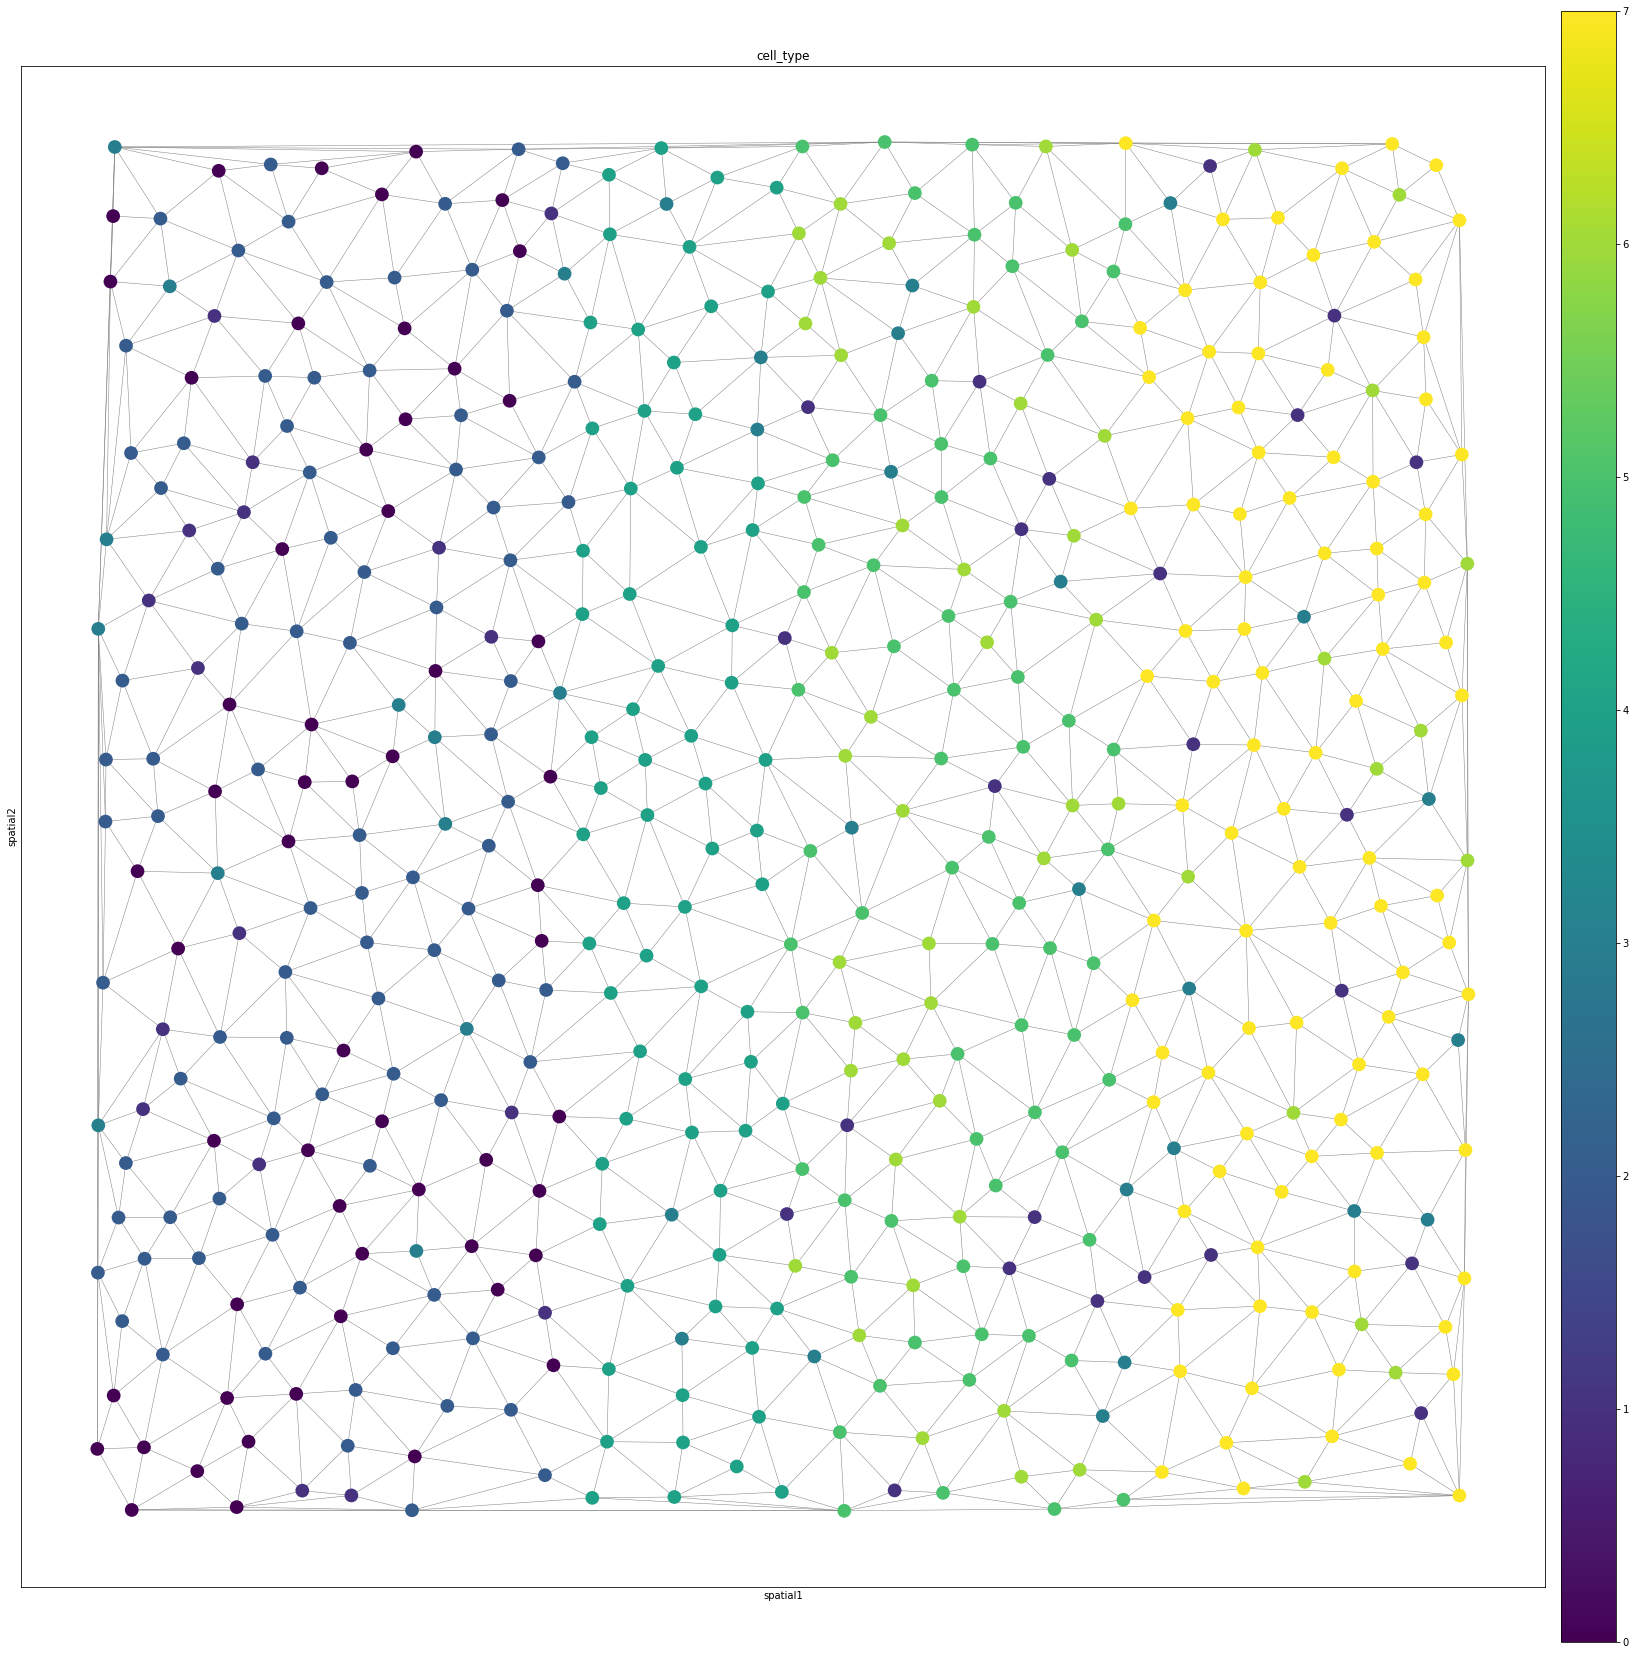

In [68]:
fig, ax = plt.subplots(figsize=(30,30))
sq.gr.spatial_neighbors(loaded_datasets[0], delaunay=True, coord_type="generic")
sc.pl.spatial(
    loaded_datasets[0],
    color="cell_type",
    neighbors_key="spatial_neighbors",
    spot_size=0.01,
    edges=True,
    edges_width=0.5,
    # img_key="segmentation",
    # alpha_img=0.5,
    ax=ax
)

In [69]:
loaded_datasets[0].uns["ground_truth_X"]["0"] @ loaded_datasets[0].uns["ground_truth_M"]["0"].T

array([[0.07662859, 0.12592046, 0.23022521, ..., 0.12997699, 0.08279287,
        0.15760359],
       [0.06604731, 0.12636562, 0.16340016, ..., 0.04598662, 0.11275423,
        0.10191156],
       [0.06395122, 0.10903323, 0.19956722, ..., 0.11482448, 0.07145133,
        0.13808375],
       ...,
       [0.05057417, 0.06247436, 0.11719459, ..., 0.05433794, 0.05298672,
        0.0581387 ],
       [0.06500668, 0.07835646, 0.14609291, ..., 0.06633231, 0.06466159,
        0.07398077],
       [0.07984358, 0.11482139, 0.22283325, ..., 0.11500073, 0.11231767,
        0.0980176 ]])

In [70]:
loaded_datasets[0].X

array([[0.67676   , 1.4879402 , 1.7273189 , ..., 1.2340802 , 0.99024177,
        0.22809485],
       [0.38261873, 0.16159742, 0.80356216, ..., 0.22940274, 0.3368963 ,
        0.7964293 ],
       [0.5198801 , 0.1569591 , 0.69054365, ..., 0.07602958, 0.18613382,
        1.0260576 ],
       ...,
       [1.4178607 , 0.52156126, 0.93837285, ..., 0.68324035, 0.6021887 ,
        0.01939524],
       [0.80953866, 0.36649638, 1.3576732 , ..., 0.02720609, 0.31638402,
        2.096648  ],
       [0.6359376 , 1.0111884 , 0.6380394 , ..., 1.0092461 , 0.7883816 ,
        1.6778986 ]], dtype=float32)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


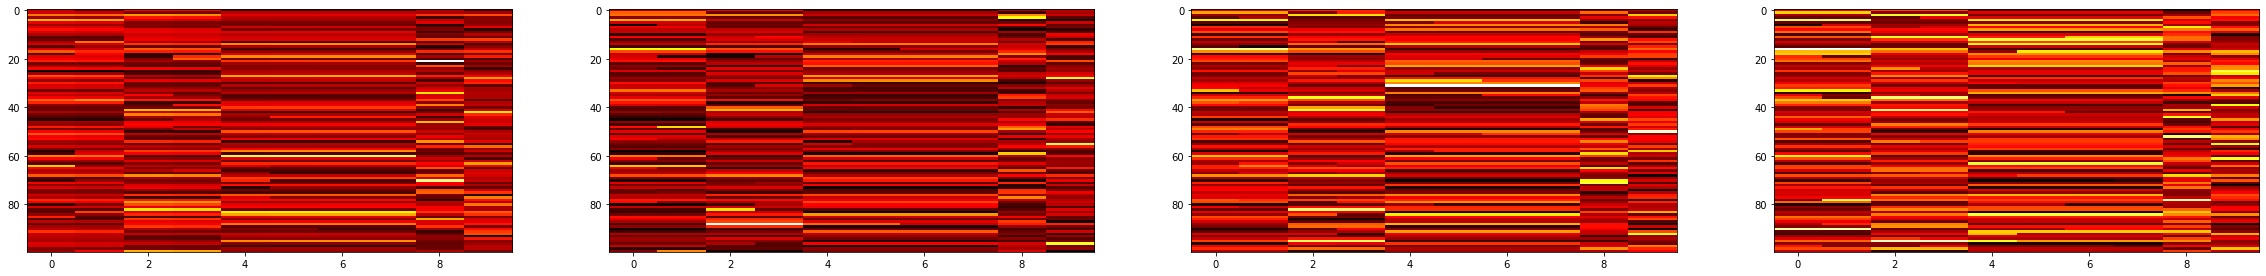

In [71]:
fig, axes = plt.subplots(1, 4, figsize=(40, 12))
for replicate, ax in zip(range(parameters["num_replicates"]), axes):
    metagenes = loaded_datasets[0].uns["ground_truth_M"][f"{replicate}"]
    ax.imshow(metagenes, cmap='hot', interpolation='nearest', aspect=0.05)
    print(metagenes.sum(axis=0))

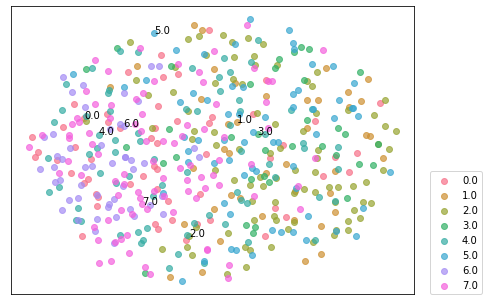

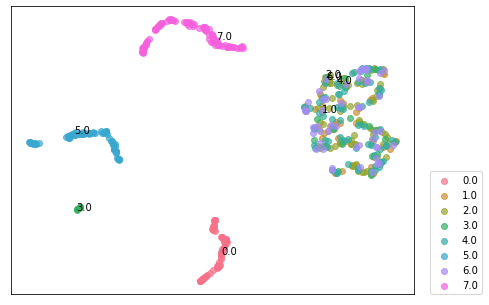

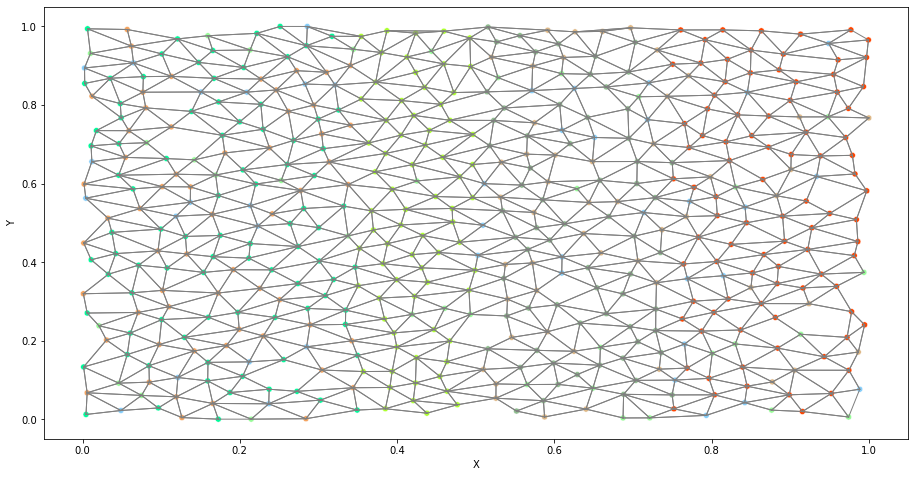

In [63]:
replicate = 1
for dataset in datasets[:1]:
    dataset.plot_cells_UMAP(latent_space=False, annotate=True, replicate=replicate)
    dataset.plot_cells_UMAP(latent_space=True, annotate=True, replicate=replicate)
    dataset.plot_cell_types(replicate=replicate)

In [29]:
for dataset in datasets:
    print(dataset.cell_type_definitions)
    dataset.plot_feature_by_cell_type(s=0.4)

[[[0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 1 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0]
  [1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]]


AttributeError: 'SyntheticCortexDataset' object has no attribute 'plot_feature_by_cell_type'

In [ ]:
rng = np.random.default_rng(12345)

num_genes = 2
num_cells = 100000
random_integers = rng.integers(low=0, high=1, size=num_genes)
random_values = np.zeros((num_cells, num_genes))
covariance_matrix = 0.05 * np.identity(num_genes)
covariance_matrix[0, 1], covariance_matrix[1, 0] = 0.02, 0.00
for cell in range(num_cells):
    random_values[cell] = sample_gaussian(covariance_matrix, random_integers)

In [ ]:
import matplotlib.pyplot as plt
x, y = random_values.T
plt.scatter(x, y)

In [ ]:
rng = np.random.default_rng(12345)

num_genes = 100
num_cells = 2000
random_integers = rng.integers(low=10, high=20, size=num_genes)
covariance_matrix = 25 * np.identity(num_genes)
covariance_matrix[0, 1], covariance_matrix[1, 0] = 0.02, 0.02
random_values = sample_truncated_gaussian(covariance_matrix, random_integers, num_cells, num_steps=1000)

In [ ]:
import matplotlib.pyplot as plt
x, y = random_values.T[:2]
plt.scatter(x, y)